In [23]:
import yaml
import zarr

repo_root = "/Users/miskodzamba/Dropbox/research/gits/spf/"
import sys

sys.path.append(repo_root)  # go to parent dir
from spf.utils import zarr_open_from_lmdb_store


root = "/Volumes/SPFData/missions/april5"
prefix = "wallarrayv3_2024_04_05_22_13_07_nRX2_rx_circle"
zarr_fn = f"{root}/{prefix}.zarr"
yaml_fn = f"{root}/{prefix}.yaml"
z = zarr_open_from_lmdb_store(zarr_fn)

yaml_config = yaml.safe_load(open(yaml_fn, "r"))

In [24]:
# self.steering_vectors = precompute_steering_vectors(
#     receiver_positions=self.rx_config.rx_pos,
#     carrier_frequency=self.rx_config.lo,
#     spacing=self.nthetas,
# )

from spf.data_collector import rx_config_from_receiver_yaml
from spf.rf import beamformer_given_steering, precompute_steering_vectors
from spf.sdrpluto.sdr_controller import get_avg_phase
import numpy as np
from matplotlib import pyplot as plt
from spf.rf import beamformer_given_steering_nomean

nthetas = 64 + 1

rx_configs = [
    rx_config_from_receiver_yaml(receiver) for receiver in yaml_config["receivers"]
]

steering_vectors = [
    precompute_steering_vectors(
        receiver_positions=rx_config.rx_pos,
        carrier_frequency=rx_config.lo,
        spacing=nthetas,
    )
    for rx_config in rx_configs
]
for rx_config in rx_configs:
    print(f"RXPOS {rx_config.rx_pos} RXLO {rx_config.lo}")


def load_zarr_to_numpy(x):
    return np.array(x)


session_idx = 150


# avg_phase_diff = get_avg_phase(signal_matrix)

RXPOS [[-0.025375  0.      ]
 [ 0.025375  0.      ]] RXLO 2412000000
RXPOS [[-0.025375  0.      ]
 [ 0.025375  0.      ]] RXLO 2412000000


In [25]:
yaml_config["receivers"]

[{'antenna-spacing-m': 0.05075,
  'array-type': 'linear',
  'bandwidth': 300000,
  'buffer-size': 524288,
  'f-carrier': 2412000000,
  'f-intermediate': 100000,
  'f-sampling': 16000000,
  'motor_channel': 0,
  'nelements': 2,
  'receiver-uri': 'ip:192.168.1.17',
  'rx-buffers': 2,
  'rx-gain': -3,
  'rx-gain-mode': 'fast_attack',
  'theta-in-pis': -0.25},
 {'antenna-spacing-m': 0.05075,
  'array-type': 'linear',
  'bandwidth': 300000,
  'buffer-size': 524288,
  'f-carrier': 2412000000,
  'f-intermediate': 100000,
  'f-sampling': 16000000,
  'motor_channel': 0,
  'nelements': 2,
  'receiver-uri': 'ip:192.168.1.18',
  'rx-buffers': 2,
  'rx-gain': -3,
  'rx-gain-mode': 'fast_attack',
  'theta-in-pis': 1.25}]

In [26]:
# beam_sds[0].shape
# beam_sds[0][offset : offset + n].shape
# beam_sds[0][:, window["start_idx"] : window["end_idx"]].shape

In [27]:
for rx_config in rx_configs:
    print(rx_config.rx_pos)

[[-0.025375  0.      ]
 [ 0.025375  0.      ]]
[[-0.025375  0.      ]
 [ 0.025375  0.      ]]


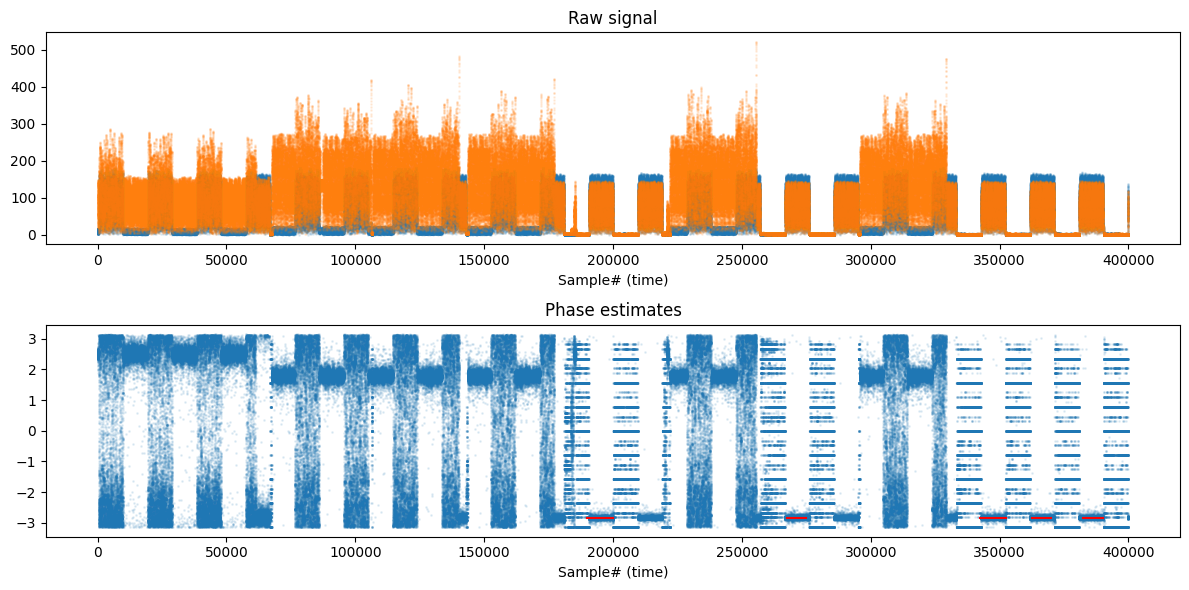

In [28]:
from spf.rf import beamformer
from spf.sdrpluto.sdr_controller import get_phase_diff

signal_matrix = load_zarr_to_numpy(z.receivers["r0"].signal_matrix[session_idx])
n = 2 * 4 * 50000
offset = 0
sub_signal_matrix = signal_matrix[:, offset : offset + n]
pd = get_phase_diff(signal_matrix[:, offset : offset + n])
v = signal_matrix[:, offset : offset + n]

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

axs[0].scatter(np.arange(n), np.abs(v[0]), alpha=0.1, s=1)
axs[0].scatter(np.arange(n), np.abs(v[1]), alpha=0.1, s=1)
axs[0].set_title("Raw signal")
axs[0].set_xlabel("Sample# (time)")
axs[1].set_xlabel("Sample# (time)")
axs[1].set_title("Phase estimates")
axs[1].scatter(np.arange(n), pd, s=1, alpha=0.1)
from spf.sdrpluto.sdr_controller import circular_mean, circular_stddev, simple_segment

beam_sds = [
    beamformer_given_steering_nomean(
        steering_vectors=steering_vectors[receiver_idx],
        signal_matrix=v,
    )
    for receiver_idx in range(2)
]

window_sds = []
for window in simple_segment(
    v,
    window_size=2500,
    stride=2500,
    trim=20,
    mean_diff_threshold=0.2,  #
    max_stddev_threshold=0.5,  # just eyeballed this
    drop_less_than_size=3000,
    min_abs_signal=40,
):
    if window["type"] == "signal":
        axs[1].plot(
            [window["start_idx"], window["end_idx"]],
            [window["mean"], window["mean"]],
            color="red",
        )
    else:
        axs[1].plot(
            [window["start_idx"], window["end_idx"]],
            [window["mean"], window["mean"]],
            color="orange",
        )
    # print(window["start_idx"], window["end_idx"])
    _beam_sds = beam_sds[0][:, window["start_idx"] : window["end_idx"]].mean(axis=1)
    # _beam_sds = _beam_sds.mean(axis=1)
    # _beam_sds -= _beam_sds.min()
    window_sds.append(_beam_sds)
window_sds = np.array(window_sds)
fig.set_tight_layout(True)

In [29]:
signal_matrix.shape

(2, 524288)

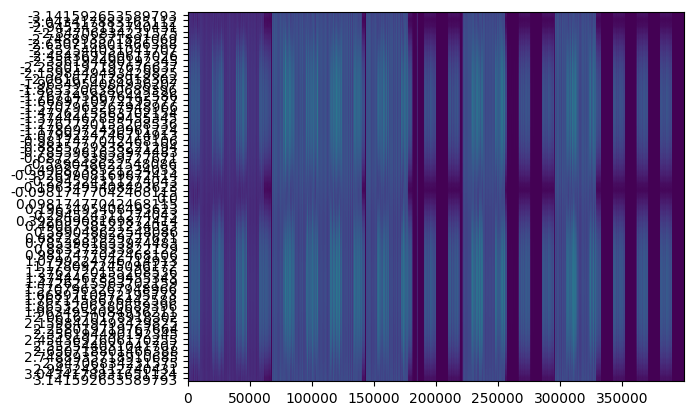

In [30]:
from spf.rf import beamformer_thetas


plt.imshow(beam_sds[0], aspect="auto")
plt.yticks(range(nthetas), beamformer_thetas(nthetas).reshape(-1))
a = 1

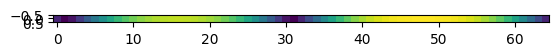

In [31]:
plt.imshow(window_sds.mean(axis=0, keepdims=True))

In [32]:
# window_sds

In [33]:
from multiprocessing.pool import ThreadPool
import os
from spf.sdrpluto.sdr_controller import (
    get_phase_diff,
    segment_session_star,
    simple_segment,
    segment_session,
)
import pickle

# z.receivers["r0"].signal_matrix.shape = (sessions, n_rx_per_receiver, samples_per_buffer)
n_sessions, _, samples_per_buffer = z.receivers["r0"].signal_matrix.shape

results_fn = "tempdata4.pkl"
if not os.path.exists(results_fn):
    z = zarr_open_from_lmdb_store(zarr_fn)
    from multiprocessing import Pool
    import time
    import tqdm

    start = time.time()
    results_by_receiver = {}
    for r_idx in [0, 1]:
        r_name = f"r{r_idx}"
        inputs = [
            {
                "zarr_fn": zarr_fn,
                "receiver": r_name,
                "session_idx": idx,
                "window_size": 2048,
                "stride": 2048,
                "trim": 20.0,
                "mean_diff_threshold": 0.2,
                "max_stddev_threshold": 0.5,
                "drop_less_than_size": 3000,
                "min_abs_signal": 40,
            }
            for idx in range(n_sessions)
        ]
        with Pool(8) as pool:
            results_by_receiver[r_name] = list(
                tqdm.tqdm(pool.imap(segment_session_star, inputs), total=len(inputs))
            )
    print(time.time() - start)

    import pickle

    pickle.dump(results_by_receiver, open(results_fn, "wb"))
else:
    results_by_receiver = pickle.load(open(results_fn, "rb"))

In [34]:
z.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='receivers', nodes=(Node(disabled=Tr…

In [35]:
1 - 1e-8

0.99999999

In [36]:
def test(a, b):
    print(b, b, a)


test(**{"a": "wtf", "b": "c"})

c c wtf


/var/folders/31/j84vsqkx1rg7zggf_0glkq8m0000gn/T/ipykernel_37654/1036782249.py:4: RuntimeWarning: Mean of empty slice.
  [np.array([x["mean"] for x in result]).mean() for result in results]
/Users/miskodzamba/.virtualenvs/spf/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Mean phase diff of seg. chunk')

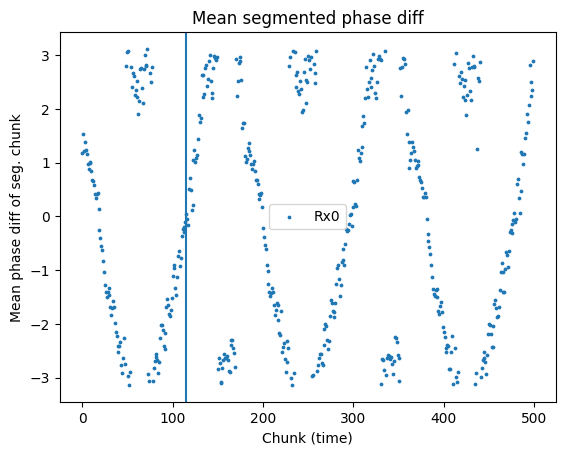

In [37]:
mean_phase_results = {}
for receiver, results in results_by_receiver.items():
    mean_phase_results[receiver] = np.array(
        [np.array([x["mean"] for x in result]).mean() for result in results]
    )


first_n = 250 * 2
fig, axs = plt.subplots(1, 1)
axs.scatter(range(first_n), mean_phase_results["r0"][:first_n], s=3, label="Rx0")
# axs.scatter(range(first_n), mean_phase_results["r1"][:first_n], s=3, label="Rx1")
axs.legend()
axs.axvline(x=115)
axs.set_title("Mean segmented phase diff")
axs.set_xlabel("Chunk (time)")
axs.set_ylabel("Mean phase diff of seg. chunk")

In [38]:
np.isfinite(np.arcsin(np.linspace(-1, 1, 1024 * 1024))).all()
np.arcsin(2)

/var/folders/31/j84vsqkx1rg7zggf_0glkq8m0000gn/T/ipykernel_37654/304832980.py:2: RuntimeWarning: invalid value encountered in arcsin
  np.arcsin(2)


nan

2412000000 0.05075


2412000000 0.05075


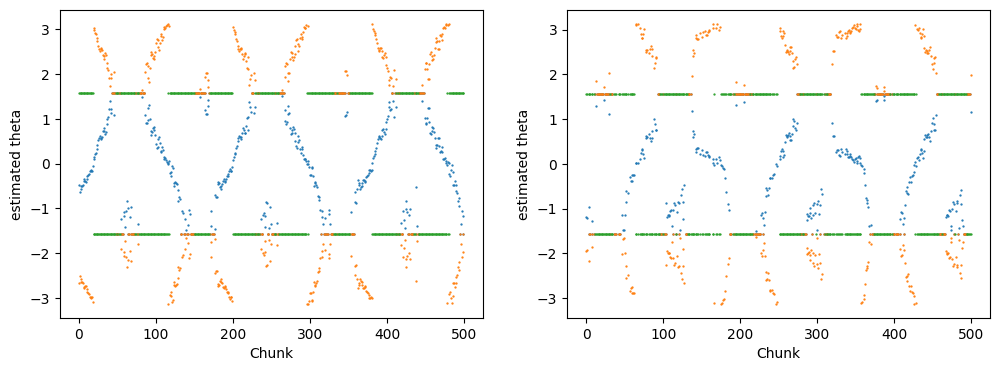

In [39]:
from spf.dataset.spf_dataset import pi_norm
from spf.rf import c as speed_of_light
from spf.sdrpluto.sdr_controller import phase_diff_to_theta


fig, axs = plt.subplots(1, 2, figsize=(12, 4))

estimated_thetas = {}
for rx_idx in [0, 1]:
    carrier_freq = yaml_config["receivers"][rx_idx]["f-carrier"]
    antenna_spacing = yaml_config["receivers"][rx_idx]["antenna-spacing-m"]
    print(carrier_freq, antenna_spacing)
    estimated_thetas[f"r{rx_idx}"] = phase_diff_to_theta(
        mean_phase_results[f"r{rx_idx}"][:first_n],
        speed_of_light / carrier_freq,
        antenna_spacing,
        large_phase_goes_right=False,
    )

    axs[rx_idx].scatter(
        range(estimated_thetas[f"r{rx_idx}"][0].shape[0]),
        pi_norm(estimated_thetas[f"r{rx_idx}"][0]),
        s=0.4,
    )
    axs[rx_idx].scatter(
        range(estimated_thetas[f"r{rx_idx}"][1].shape[0]),
        pi_norm(estimated_thetas[f"r{rx_idx}"][1]),
        s=0.4,
    )
    axs[rx_idx].scatter(
        range(estimated_thetas[f"r{rx_idx}"][2].shape[0]),
        pi_norm(estimated_thetas[f"r{rx_idx}"][2]),
        s=0.4,
    )
    axs[rx_idx].set_xlabel("Chunk")
    axs[rx_idx].set_ylabel("estimated theta")

(500, 2)


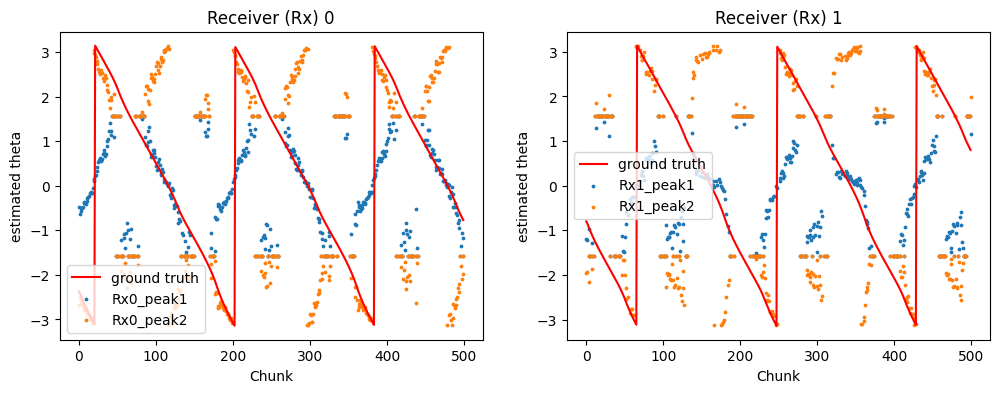

In [40]:
from spf.dataset.spf_dataset import pi_norm


tx_pos = np.vstack(
    [
        z.receivers.r0.tx_pos_x_mm,
        z.receivers.r0.tx_pos_y_mm,
    ]
).T
rx_pos = np.array(
    [
        z.receivers.r0.rx_pos_x_mm,
        z.receivers.r0.rx_pos_y_mm,
    ]
).T
d = (tx_pos - rx_pos)[:first_n]
rx_to_tx_theta = np.arctan2(d[:, 0], d[:, 1])

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for rx_idx in [0, 1]:
    expected_theta = pi_norm(
        rx_to_tx_theta - z.receivers[f"r{rx_idx}"].rx_theta_in_pis[:first_n] * np.pi
    )
    axs[rx_idx].plot(expected_theta, alpha=1, color="red", label="ground truth")

    n = estimated_thetas[f"r{rx_idx}"][0].shape[0]
    axs[rx_idx].scatter(
        range(n),
        pi_norm(estimated_thetas[f"r{rx_idx}"][0]),
        s=3,
        label=f"Rx{rx_idx}_peak1",
    )
    axs[rx_idx].scatter(
        range(n),
        pi_norm(estimated_thetas[f"r{rx_idx}"][1]),
        s=3,
        label=f"Rx{rx_idx}_peak2",
    )
    axs[rx_idx].set_xlabel("Chunk")
    axs[rx_idx].set_ylabel("estimated theta")
    axs[rx_idx].legend()
    axs[rx_idx].set_title(f"Receiver (Rx) {rx_idx}")

print(d.shape)

In [42]:
rx_pos.shape

(5000, 2)

In [15]:
# compute tables for both
from spf.sdrpluto.sdr_controller import circular_diff_to_mean


estimated_theta_by_receiver_and_angle = {}

angle_resolution = 24


def theta_to_bin(theta, angle_resolution):
    zero_to_one_normed = (pi_norm(theta) / np.pi + 1) / 2
    return np.rint(zero_to_one_normed * angle_resolution)


def bin_to_theta(bin, angle_resolution):
    return ((bin / angle_resolution) * 2 - 1) * np.pi


for rx_idx in [0, 1]:
    expected_theta = pi_norm(
        rx_to_tx_theta - z.receivers[f"r{rx_idx}"].rx_theta_in_pis[:first_n] * np.pi
    )

    theta_bins = theta_to_bin(expected_theta, angle_resolution=angle_resolution)

    diff_to_estimated_values = np.array(
        [
            circular_diff_to_mean(expected_theta, estimated_thetas[f"r{rx_idx}"][0]),
            circular_diff_to_mean(expected_theta, estimated_thetas[f"r{rx_idx}"][1]),
        ]
    ).min(axis=0)

    results_by_bin_dict = {idx: [] for idx in range(angle_resolution)}
    for idx in range(theta_bins.shape[0]):
        bin = theta_bins[idx]
        assert 0 <= bin and bin <= angle_resolution
        bin = bin % angle_resolution
        results_by_bin_dict[bin].append(diff_to_estimated_values[idx])

    means_by_bin = np.zeros(angle_resolution)
    stddevs_by_bin = np.zeros(angle_resolution)
    for bin in range(angle_resolution):
        means_by_bin[bin] = np.array(results_by_bin_dict[bin]).mean()
        stddevs_by_bin[bin] = np.array(results_by_bin_dict[bin]).std()

    estimated_theta_by_receiver_and_angle[f"r{rx_idx}"] = {
        "mean": means_by_bin,
        "std": stddevs_by_bin,
    }

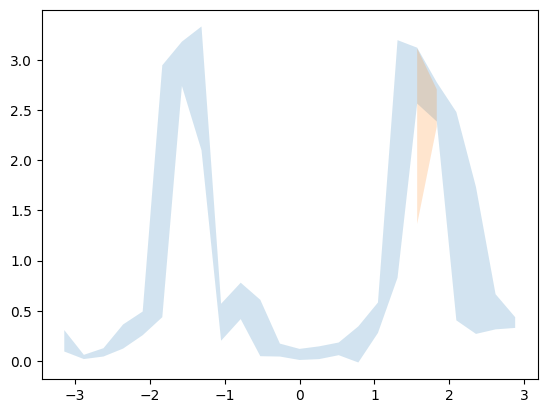

In [16]:
for rx_idx in [0, 1]:
    stats = estimated_theta_by_receiver_and_angle[f"r{rx_idx}"]
    plt.fill_between(
        x=bin_to_theta(np.arange(angle_resolution), angle_resolution),
        y1=stats["mean"] - stats["std"],
        y2=stats["mean"] + stats["std"],
        alpha=0.2,
    )

0.030595855642370107

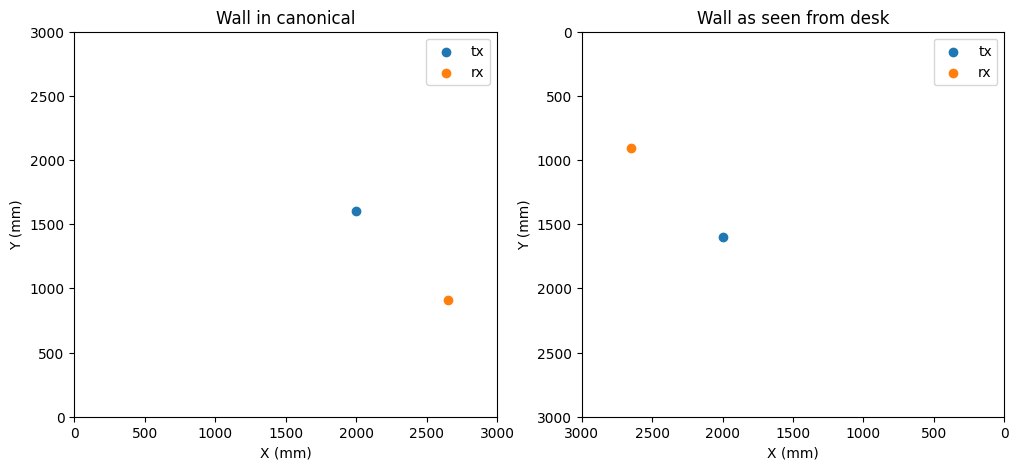

In [17]:
session_idx = 115
rx_theta_in_pis = z.receivers.r0.rx_theta_in_pis[session_idx]
tx_pos = np.array(
    [
        z.receivers.r0.tx_pos_x_mm[session_idx],
        z.receivers.r0.tx_pos_y_mm[session_idx],
    ]
)
rx_pos = np.array(
    [
        z.receivers.r0.rx_pos_x_mm[session_idx],
        z.receivers.r0.rx_pos_y_mm[session_idx],
    ]
)


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for idx in [0, 1]:
    axs[idx].scatter(tx_pos[0], tx_pos[1], label="tx")
    axs[idx].scatter(rx_pos[0], rx_pos[1], label="rx")
    axs[idx].set_xlabel("X (mm)")
    axs[idx].set_ylabel("Y (mm)")
    axs[idx].set_xlim([0, 3000])
    axs[idx].set_ylim([0, 3000])
    axs[idx].legend()

axs[0].set_title("Wall in canonical")
axs[1].set_title("Wall as seen from desk")
axs[1].invert_xaxis()
axs[1].invert_yaxis()

# compute the angle of the tx with respect to rx
d = tx_pos - rx_pos
rx_to_tx_theta = np.arctan2(d[0], d[1])
rx_axis_to_tx_theta = rx_to_tx_theta - rx_theta_in_pis * np.pi
rx_axis_to_tx_theta

In [16]:
len(results)

5000

In [ ]:
from spf.rf import ULADetector


pos = ULADetector(
    sampling_frequency=None,
    n_elements=2,
    spacing=0.05075 * 1000,
    orientation=1.25 * np.pi,
).all_receiver_pos()
pos[1]

array([-17.94283457,  17.94283457])

In [ ]:
z = zarr_open_from_lmdb_store(zarr_fn)
z.store.db.info()

{'map_addr': 0,
 'map_size': 274877906944,
 'last_pgno': 3971938,
 'last_txnid': 120026,
 'max_readers': 1048576,
 'num_readers': 1}

In [ ]:
def test():
    try:
        yield 1
    finally:
        print("WTF")


a = test()
print("OK")
a = None

OK


In [ ]:
zarr_fn
with zarr_open_from_lmdb_store_cm(zarr_fn) as z:
    pass

In [ ]:
from spf.utils import zarr_open_from_lmdb_store_cm


start = time.time()
results = list(
    map(
        lambda x: segment_session(zarr_fn, "r0", x, 2048, 1024, 20, 0.2, 0.15),
        range(100),
    )
)
print(time.time() - start)

8.502942085266113


In [ ]:
from numba import njit

repo_root = "/Users/miskodzamba/Dropbox/research/gits/spf/"
import sys
import numpy as np

sys.path.append(repo_root)  # go to parent dir
from spf.utils import random_signal_matrix


@njit
def pi_norm(x):
    return ((x + np.pi) % (2 * np.pi)) - np.pi


@njit
def get_phase_diff(signal_matrix):
    return pi_norm(np.angle(signal_matrix[0]) - np.angle(signal_matrix[1]))


z = random_signal_matrix(n=200)

get_phase_diff(z)

-3.0825503936205294

In [ ]:
fake_signal.shape

NameError: name 'fake_signal' is not defined

In [ ]:
z.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='receivers', nodes=(Node(disabled=Tr…

In [ ]:
z.receivers.r0.signal_matrix[0].shape

In [15]:
import numpy as np


def random_signal_matrix(n):
    return np.random.uniform(-1, 1, (n,)) + 1.0j * np.random.uniform(-1, 1, (n,))


signal_matrix = random_signal_matrix(1200).reshape(2, 600)

ground_truth_windows = [
    {"start_idx": 0, "end_idx": 200, "mean": 0.5},
    {"start_idx": 300, "end_idx": 400, "mean": 1.3},
    {"start_idx": 450, "end_idx": 550, "mean": 1.25},
]

for window in ground_truth_windows:
    signal_matrix[1, window["start_idx"] : window["end_idx"]] *= 10
    signal_matrix[1, window["start_idx"] : window["end_idx"]] = signal_matrix[
        0, window["start_idx"] : window["end_idx"]
    ] * np.exp(1j * window["mean"])

In [20]:
from spf.sdrpluto.sdr_controller import (
    combine_windows,
    get_phase_diff,
    windowed_trimmed_circular_mean_and_stddev,
)
import matplotlib.pyplot as plt


def simple_segment2(
    v,
    window_size,
    stride,
    trim,
    mean_diff_threshold,
    max_stddev_threshold,
    drop_less_than_size,
    min_abs_signal,
):
    pd = get_phase_diff(v)
    candidate_windows = []
    window_idxs_and_stats = windowed_trimmed_circular_mean_and_stddev(
        v, pd, window_size=window_size, stride=stride, trim=trim
    )
    candidate_windows = [
        {
            "start_idx": idx[0],
            "end_idx": idx[1],
            "mean": stats[0],
            "stddev": stats[1],
            "abs_signal_median": stats[2],
        }
        for idx, stats in zip(window_idxs_and_stats[0], window_idxs_and_stats[1])
    ]

    # combine windows
    candidate_windows = combine_windows(
        candidate_windows, max_stddev_threshold, min_abs_signal
    )
    # drop all noise windows less than 3windows in size
    candidate_windows = drop_windows_smaller_than(
        candidate_windows, drop_less_than_size
    )

    # only keep signal windows surounded by noise
    candidate_windows = keep_signal_surrounded_by_noise(candidate_windows)

    return recompute_stats_for_windows(candidate_windows, v, pd, trim)


pd = get_phase_diff(signal_matrix)

segmented_windows = simple_segment2(
    signal_matrix,
    window_size=100,
    stride=50,
    trim=0,
    mean_diff_threshold=0.05,
    max_stddev_threshold=0.1,
    drop_less_than_size=0,
    min_abs_signal=10,
)

NameError: name 'drop_windows_smaller_than' is not defined

In [21]:
segmented_windows

[{'start_idx': 0,
  'end_idx': 200,
  'mean': -0.5,
  'stddev': 6.312009177722025e-17,
  'abs_signal_median': 0.8322920948974496,
  'type': 'signal'},
 {'start_idx': 150,
  'end_idx': 350,
  'mean': -0.6353122253637338,
  'stddev': 1.1424238987235638,
  'abs_signal_median': 0.8076122707259219,
  'type': 'noise'},
 {'start_idx': 300,
  'end_idx': 400,
  'mean': -1.3000000000000007,
  'stddev': 6.323833120356729e-16,
  'abs_signal_median': 0.8169637885095236,
  'type': 'signal'},
 {'start_idx': 350,
  'end_idx': 500,
  'mean': -1.2266251536510424,
  'stddev': 1.1911853588106636,
  'abs_signal_median': 0.8110098757397326,
  'type': 'noise'},
 {'start_idx': 450,
  'end_idx': 550,
  'mean': -1.25,
  'stddev': 1.0932720593655597e-16,
  'abs_signal_median': 0.8270408814387666,
  'type': 'signal'},
 {'start_idx': 500,
  'end_idx': 600,
  'mean': -1.4000441041027276,
  'stddev': 1.3785013552618555,
  'abs_signal_median': 0.8018514114365385,
  'type': 'noise'}]

In [5]:
from spf.sdrpluto.sdr_controller import circular_mean

circular_mean(pd[:100])

(-0.5, -0.5)

In [6]:
from spf.sdrpluto.sdr_controller import get_stats_for_signal


def windowed_trimmed_circular_mean_and_stddev2(v, pd, window_size, stride, trim=50.0):
    assert (pd.shape[0] - window_size) % stride == 0
    n_steps = 1 + (pd.shape[0] - window_size) // stride

    step_idxs = np.zeros((n_steps, 2), dtype=np.int64)
    step_stats = np.zeros((n_steps, 3), dtype=np.float64)
    steps = np.arange(n_steps)

    # start_idx, end_idx
    step_idxs[:, 0] = steps * stride
    step_idxs[:, 1] = step_idxs[:, 0] + window_size
    for step in range(n_steps):
        start_idx, end_idx = step_idxs[step][:2]
        _pd = pd[start_idx:end_idx]
        _v = v[:, start_idx:end_idx]
        print(_pd)
        # trimmed_cm, trimmed_stddev, abs_signal_median
        step_stats[step] = get_stats_for_signal(_v, _pd, trim)

    return step_idxs, step_stats


v = signal_matrix[:, :100]
pd = get_phase_diff(v)
window_idxs_and_stats = windowed_trimmed_circular_mean_and_stddev2(
    v, pd, window_size=100, stride=50, trim=0
)

[-0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5]


In [7]:
window_idxs_and_stats

(array([[  0, 100]]), array([[-0.5       ,  0.        ,  0.77483402]]))

In [8]:
circular_mean(pd, trim=0)

(-0.5, -0.5)